<a href="https://colab.research.google.com/github/youavang/Covid-19_CT_Scan_Prediction/blob/main/Dataset_Exploration_COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi #show the allocated GPU

Sat Dec 19 18:06:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Install essential libraries
!pip install zipfile36

In [ ]:
import keras
import numpy as np
import cv2
import os
import random
import shutil
import pandas as pd
import csv
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
from keras import optimizers
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense,Input, AveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import RandomNormal
from sklearn.utils import shuffle
import io
from PIL import Image as pil_image
import keras.backend as k

In [ ]:
archive = zipfile.ZipFile("drive/My Drive/Train&Validation.zip") #Path to the shared data for training and validation
for file in archive.namelist():
     archive.extract(file, './data') #Extract the data

In [ ]:
fold_num=4 #Select Fold Number

In [ ]:
#Here we set the data generators for applying data augmentation methods
train_datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,zoom_range=0.05,rotation_range=360,width_shift_range=0.05,height_shift_range=0.05,shear_range=0.05)
test_datagen = ImageDataGenerator()
train_df =pd.read_csv('drive/My Drive/CSV/train{}.csv'.format(fold_num)) #read train csv file
validation_df = pd.read_csv('drive/My Drive/CSV/validation{}.csv'.format(fold_num)) #read validation csv file (Validation in the training process)
train_df = shuffle(train_df) #Shuffle the train data
test_df = pd.read_csv('drive/My Drive/CSV/test{}.csv'.format(fold_num))#read test csv file (For evaluating the final version of the trained network)

In [ ]:
shape=(512,512,1) #shape of the dataset images (in TIFF format)

In [ ]:
#Create the generators
train_generator = train_datagen.flow_from_dataframe(
      dataframe=train_df,
      directory='data',
      x_col="filename",
      y_col="class",
      target_size=shape[:2],
      batch_size=10,
      class_mode='categorical',color_mode="grayscale",shuffle=True)
validation_generator = test_datagen.flow_from_dataframe(
        dataframe=validation_df,
        directory='data',
        x_col="filename",
        y_col="class",
        target_size=shape[:2],
        batch_size=10,
        class_mode='categorical',color_mode="grayscale",shuffle=True)
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory='data',
        x_col="filename",
        y_col="class",
        target_size=shape[:2],
        batch_size=10,
        class_mode='categorical',color_mode="grayscale",shuffle=True)

Found 3743 validated image filenames belonging to 2 classes.
Found 909 validated image filenames belonging to 2 classes.
Found 8315 validated image filenames belonging to 2 classes.


In [ ]:
train_df['class'].value_counts()

normal    1920
covid     1823
Name: class, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


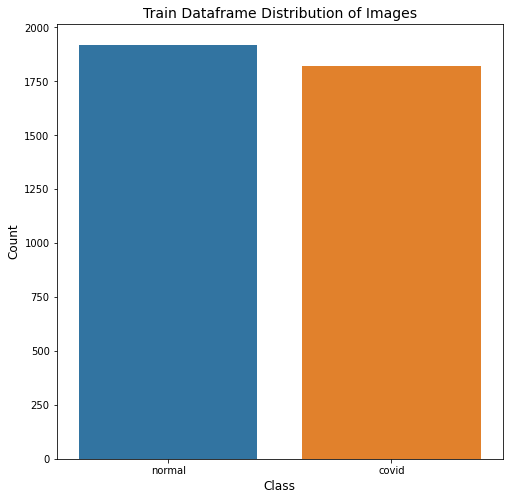

In [ ]:
# Get distribution of train dataframe

fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(train_df['class'])
ax.set_title('Train Dataframe Distribution of Images', fontsize=14)
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.show()

In [ ]:
validation_df['class'].value_counts()

covid     459
normal    450
Name: class, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


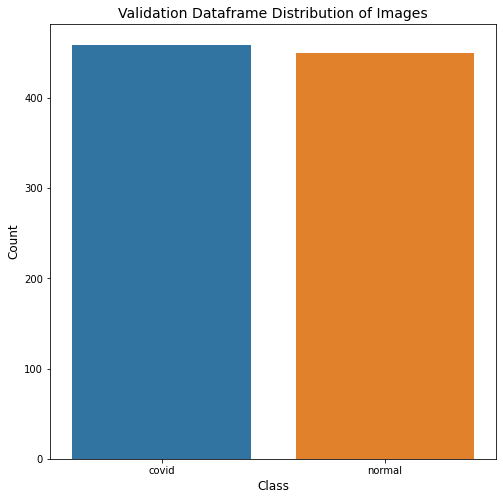

In [ ]:
# Get distribution of validation dataframe

fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(validation_df['class'])
ax.set_title('Validation Dataframe Distribution of Images', fontsize=14)
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.show()

In [ ]:
test_df['class'].value_counts()

normal    7856
covid      459
Name: class, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


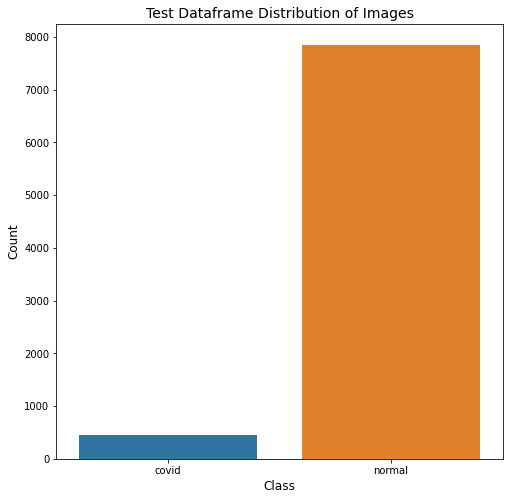

In [ ]:
# Get distribution of test dataframe

fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(test_df['class'])
ax.set_title('Test Dataframe Distribution of Images', fontsize=14)
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.show()

In [ ]:
covid_label=train_generator.class_indices['covid']
print(covid_label)

0


In [ ]:
normal_label=train_generator.class_indices['normal']
print(normal_label)

1
